# Recognition Parametrized Model (RPM): Peer Supervision


Observations $\mathcal{X} = \{ x_j \}$ are groups of MNIST images representing $J$ different renderings of the same digit. The RPM to extract this information without explicit label information - a setting that might be termed "peer-supervision". The model writes:

$$ \mathsf{P_{\theta}}(\mathcal{X}, \mathcal{Z}) = \mathsf{p_{\theta_z}}(\mathcal{Z}) \prod_{j} \left( \mathsf{p_{0,j}}(\mathsf{x_{j}}) \frac{\mathsf{f_{\theta j}}(\mathsf{\mathcal{Z}} | \mathsf{x_{j}})}{\mathsf{F_{\theta j}}(\mathcal{Z})} \right) $$

## Load and Rearanged MNIST

In [1]:
import pickle
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from utils_process import plot_loss

import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

from utils_demo import rearrange_mnist

from fast_rpm import RPM
import torch.nn.functional as F


data_folder = './../MNIST'

# Load MNIST
train_data = datasets.MNIST(
    root=data_folder,
    train=True,
    transform=ToTensor(),
    download=True,
)

test_data = datasets.MNIST(
    root=data_folder,
    train=False,
    transform=ToTensor()
)

# Random seeds
torch.manual_seed(10)

# Number of Conditionally independent Factors
num_factors = 3

# Sub-Sample original dataset
train_length = 60000

# Keep Only some digits (for efficiency)
sub_ids = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
sub_ids = torch.tensor([0, 1])
num_digits = len(sub_ids)

# Rearrange MNIST by grouping num_factors Conditionally independent Observations together
observations, train_images, train_labels = rearrange_mnist(
    train_data.train_data, 
    train_data.train_labels, 
    num_factors, 
    train_length=train_length,
    sub_ids=sub_ids
)

# Rearrange MNIST by grouping num_factors Conditionally independent Observations together
observations_test, test_images, test_labels = rearrange_mnist(
    test_data.test_data, 
    test_data.test_labels, 
    num_factors, 
    train_length=test_data.test_labels.shape[0],
    sub_ids=sub_ids
)
test_labels = test_labels.reshape(observations_test[0].shape[0], num_factors)
            

/nfs/ghome/live/hugos/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/nfs/ghome/live/hugos/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/nfs/ghome/live/hugos/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/nfs/ghome/live/hugos/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


## Move to GPU

In [2]:
# GPUs ?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data type: float64 / float32
data_type = torch.float32
torch.set_default_dtype(data_type)

Jnoise = 1
observations[Jnoise] += 8 * observations[Jnoise].abs().max() * torch.rand(observations[Jnoise].shape)
observations_test[Jnoise] += 8 * observations_test[Jnoise].abs().max() * torch.rand(observations_test[Jnoise].shape)

# Training Move to GPU
obs = [(obsi / obsi.max()).to(device) for obsi in observations]

# Testing Move to GPU
obs_test = [(obsi / obsi.max()).to(device) for obsi in observations_test]


## Typical Observations

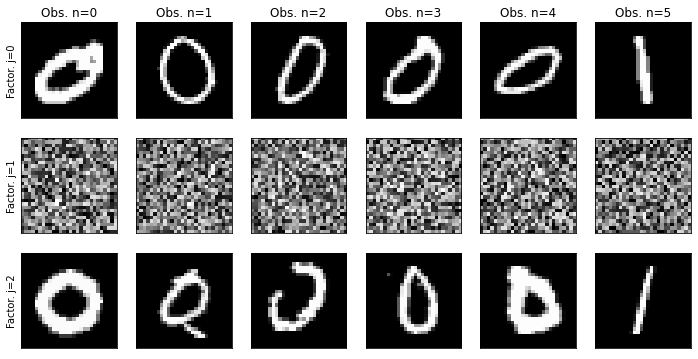

In [678]:
num_plot = np.arange(6)
plt.figure(figsize=(len(num_plot)*2, num_factors*2))
for obsi in range(len(num_plot)):
    for facti in range(num_factors):
        plt.subplot(num_factors, len(num_plot), (1+obsi) + facti * len(num_plot))
        plt.imshow(obs[facti][num_plot[obsi], :, :].cpu().numpy(), cmap='gray')
        plt.xticks([])
        plt.yticks([])
        if facti == 0:
            plt.title('Obs. n=' + str(obsi))
        if obsi == 0:
            plt.ylabel('Factor. j=' + str(facti))

## Fit

In [679]:
# Fit params
fit_params = {
    'num_epoch': 300,
    'batch_size': 1000,
    'dim_latent': 2,
    'auxiliary_mode': 'constrained_prior', # flexible, constrained_prior, constrained_moment_matched
    'factors_params': factors_params,
    #'auxiliary_params': factors_params,
    'pct': 0.01,
} 



factors_params = {
    'channels': [[1, 30, 30], [1, 30, 30], [1, 30, 30]],
    'kernel_conv': [[5, 5], [5, 5], [5, 5]],
    'kernel_pool': [[1, 2], [1, 2], [1, 2]],
    'dim_hidden': [[20, 20], [20, 20], [20, 20]],
    'nonlinearity': [F.relu, F.relu, F.relu],
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-3),
    #'dropout': [0.2, 0.2, 0.2]
}

prior_params = {
    'num_centroids':2,
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-3),
}

variational_params = {
    'dim_hidden': [],
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-3),
    'non_linearity':torch.nn.Identity(),
}

fit_params = {
    'num_epoch': 4000,
    'batch_size': 1000,
    'dim_latent': 2,
    'auxiliary_mode': 'constrained_moment_matched', # flexible, constrained_prior, constrained_moment_matched
    'factors_params': factors_params,
    'prior_params': prior_params,
    'variational_params':variational_params,
    'pct': 0.1,
} 

rpm = RPM(
    observations=obs,
    fit_params=fit_params,
)

rpm.fit(obs)

RPM on GPU Observations on cuda:0
Epoch 400/4000 Loss: 1.894068e+01
Epoch 800/4000 Loss: 1.760494e+01
Epoch 1200/4000 Loss: 1.675557e+01
Epoch 1600/4000 Loss: 1.604458e+01
Epoch 2000/4000 Loss: 1.542231e+01
Epoch 2400/4000 Loss: 1.511282e+01
Epoch 2800/4000 Loss: 1.482425e+01
Epoch 3200/4000 Loss: 1.442255e+01
Epoch 3600/4000 Loss: 1.421478e+01
Epoch 4000/4000 Loss: 1.368686e+01


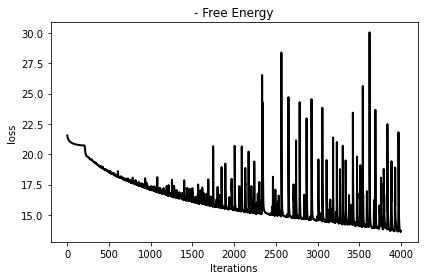

In [681]:
plot_loss(rpm, offset=0)

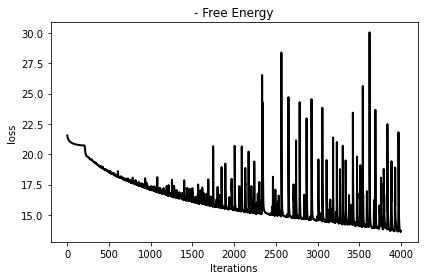

In [680]:
plot_loss(rpm, offset=0)

## Latent Distribution Embeddings of test images

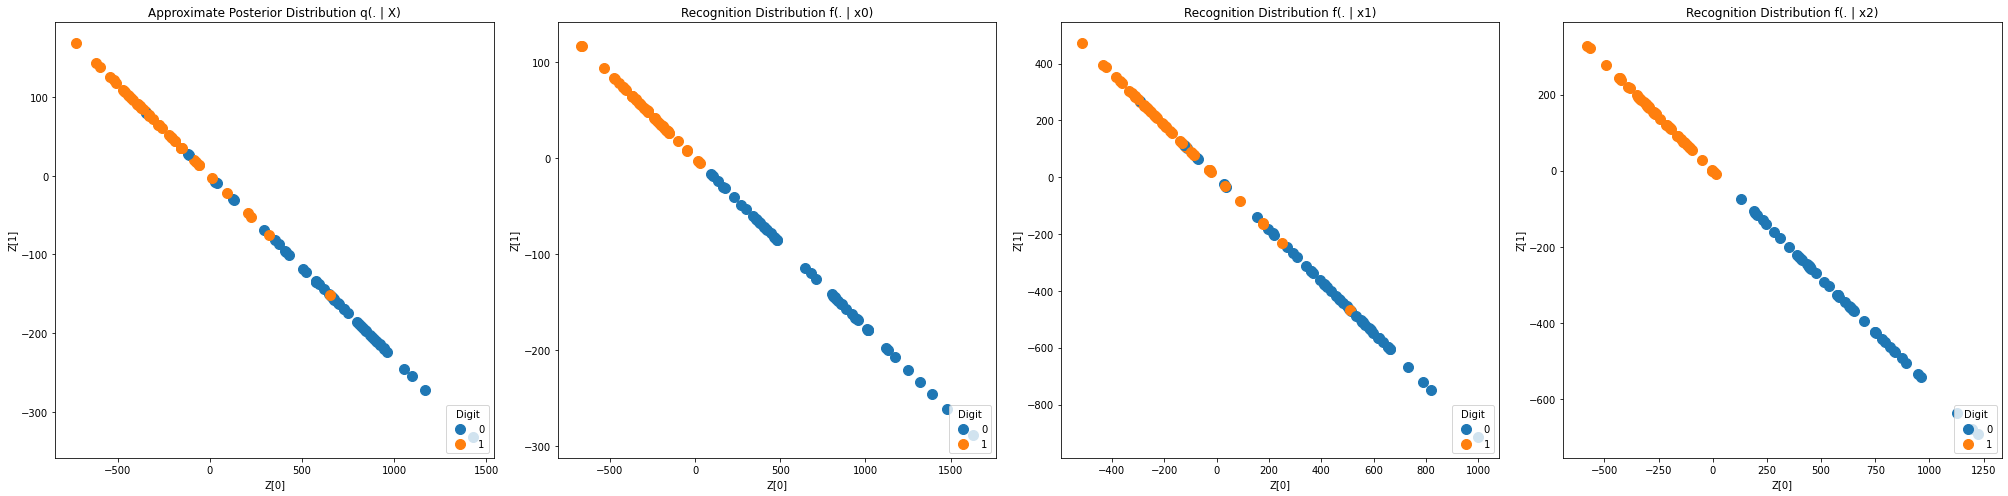

In [682]:
# Forward test data
import utils_process

dim_latent = rpm.dim_latent
heigh = int(dim_latent * (dim_latent - 1) / 2)
width = rpm.num_factors + 1
plt.figure(figsize=(width * 7, heigh * 7))  


for J in range(-1, rpm.num_factors):

    #J = 0
    qdist, fdist = rpm.get_posteriors(obs_test)

    if J == -1:
        mean, vari = qdist.mean_covariance()
        title_str = 'Approximate Posterior Distribution q(. | X)'
    else:
        mean, vari = fdist.mean_covariance()
        mean = mean[J]
        vari = vari[J]
        title_str = 'Recognition Distribution f(. | x' + str(J) + ')'

    mean = mean.detach().clone().cpu().numpy()
    vari = vari.detach().clone().cpu().numpy()


    # Plot testing Data
    subset = 100
    xx = mean[:subset]
    zz = vari[:subset]
    yy = test_labels[:subset, J]
    cmap = plt.get_cmap("tab10")
    
    
    xmaxmin = np.abs(xx).max() + 0.5 * np.sqrt(zz.diagonal(axis1= -1, axis2=-2).max())
    
    compt = 0
    for uu in range(dim_latent -1):
        for vv in range(uu+1, dim_latent):
            offset = width * compt 
            compt += 1
            
            ax = plt.subplot(heigh, width, J + 2 + offset)
            for ii in range(subset):
                y0 = int(yy[ii].numpy())
                x0 = xx[ii]
                z0 = zz[ii]
                plt.scatter(x0[uu], x0[vv], s=100, color=cmap(y0))
                utils_process.confidence_ellipse(x0[[uu, vv]], z0[[uu, vv]][:, [uu, vv]], ax, n_std=1.0, facecolor=cmap(y0), alpha=0.1)
                
            for ii in np.unique(yy):
                y0 = yy[np.where(yy == ii)]
                x0 = xx[np.where(yy == ii)]
                plt.scatter(x0[0, uu], x0[0, vv], s=100, label=str(int(ii)), color=cmap(int(y0[0].numpy())))

            plt.legend(title = 'Digit', loc= 'lower right')
            plt.xlabel('Z[' + str(uu) + ']')
            plt.ylabel('Z[' + str(vv) + ']')
            plt.title(title_str)
            xmaxmin = 3
            #plt.xlim([-xmaxmin, xmaxmin])
            #plt.ylim([-xmaxmin, xmaxmin])
            plt.tight_layout()

In [683]:
from flexible_multivariate_normal import FlexibleMultivariateNormal

qmean, qvar = qdist.mean_covariance()
fmean, fvar = fdist.mean_covariance()
#n1, n2 = [xx.clone().detach() for xx in rpm.forwarded_prior]
#pmean, pvar = FlexibleMultivariateNormal(n1, n2, init_cholesky=False, init_natural=True, store_suff_stat_mean=True).mean_covariance()
#pmean = pmean.cpu().numpy()
#pvar = pvar.cpu().numpy()



In [684]:
print(fvar[:, 0].diagonal(dim1=-1, dim2= -2))
print('')
print(qvar[0].diagonal(dim1=-1, dim2= -2))

tensor([[341.9375,  12.3867],
        [ 10.4766,   9.1250],
        [290.0000,  93.2422]], device='cuda:0')

tensor([17.8750,  1.3926], device='cuda:0')


tensor([[-10.0000],
        [ -7.7778],
        [ -5.5556],
        [ -3.3333],
        [ -1.1111],
        [  1.1111],
        [  3.3333],
        [  5.5556],
        [  7.7778],
        [ 10.0000]])

In [12]:
# Fit params
dim_latent_true = 1
num_observations = 200
dim_observations = 10
num_factors =  3

# Random seeds
torch.manual_seed(4) # was 1, 4 (100)
np.random.seed(4)    # was 1, 4 (100)

torch.manual_seed(47654) 
np.random.seed(487654)    

#zlatent = torch.randn(num_observations, dim_latent_true, device=device)

num_cluster = 3
mean_cluster = 20 * torch.randn(num_cluster, dim_latent_true, device=device)
mean_cluster = 8 * torch.linspace(-1, 1, num_cluster, device=device).unsqueeze(-1)
means = mean_cluster[np.random.choice(range(num_cluster), num_observations, replace=True)]
zlatent = 1 * torch.randn(num_observations, dim_latent_true, device=device) +  means


Jvar = 1
link_factors = torch.rand(num_factors, dim_observations, dim_latent_true, device=device)
vari_factors = 0.1 * torch.eye(dim_observations, device=device).unsqueeze(0).repeat(num_factors, 1, 1)
vari_factors[Jvar] = vari_factors[Jvar] * 10

noise = torch.sqrt(vari_factors.diagonal(dim1=-1,dim2=-2).unsqueeze(1)) * torch.randn(num_factors, num_observations, dim_observations, device=device)
observations = torch.matmul(link_factors.unsqueeze(1), zlatent.unsqueeze(0).unsqueeze(-1)).squeeze(-1) + noise
observations = [obsi for obsi in observations]



factors_params = {
    'dim_hidden': [[], [], [], []],
    'non_linearity': [torch.nn.Identity(), torch.nn.Identity(), torch.nn.Identity(), torch.nn.Identity()],
    'optimizer': lambda params: torch.optim.AdamW(params=params, lr=1e-2, weight_decay=0.0),
    #'dropout': [0.01, 0.01, 0.01],
}

prior_params = {
    'num_centroids':num_cluster,
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-2, weight_decay=0.0),
}

variational_params = {
    'dim_hidden': [],
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-2, weight_decay=0.0),
    'non_linearity':torch.nn.Identity(),
}

fit_params = {
    'num_epoch': 10000,
    'dim_latent': 1,
    'auxiliary_mode': 'constrained_moment_matched', # flexible, constrained_prior, constrained_moment_matched
    'factors_params': factors_params,
    'prior_params': prior_params,
    'variational_params':variational_params,
    'pct': 0.1,
} 

rpm = RPM(
    observations=observations,
    fit_params=fit_params,
)

# Thoughts: The noise must be "filtrable" for the estimated covariance to be accurate ? + Why does it work on unimodal ??? 
#rpm.recognition_factors[0].non_linearity
rpm.fit(observations)


# state_dict_q = rpm.recognition_variational.state_dict()
# state_dict_f = [facti.state_dict() for facti in rpm.recognition_factors]

# print(rpm.recognition_variational.state_dict())

# state_dict_q['layers.0.weight'] = state_dict_q['layers.0.weight'] * 0 + 1/3
# state_dict_q['layers.0.bias'] *= 0
# #state_dict_q['layers.0.weight'][0][0] *= -1
# #state_dict_q['layers.0.weight'][0] *= -1

# # Random seeds
# #torch.manual_seed(1) # 1 does not work but 1000 does 
# #np.random.seed(1)  # 
# # rpm = RPM(
# #     observations=observations,
# #     fit_params=fit_params,
# # )
# # print(rpm.recognition_variational.state_dict())

# # Copy the state dictionnaries
# rpm.recognition_variational.load_state_dict(state_dict_q)
# # for facti , dicti in zip(rpm.recognition_factors, state_dict_f):
# #     facti.load_state_dict(dicti)
# print(rpm.recognition_variational.state_dict())



RPM on GPU Observations on cuda:0
Pre-Training Completed. Stop Criterion Reached.
Epoch 1000/10000 Loss: 1.209836e+01
Epoch 2000/10000 Loss: 1.209256e+01
Epoch 3000/10000 Loss: 1.209391e+01
Epoch 4000/10000 Loss: 1.210016e+01


KeyboardInterrupt: 

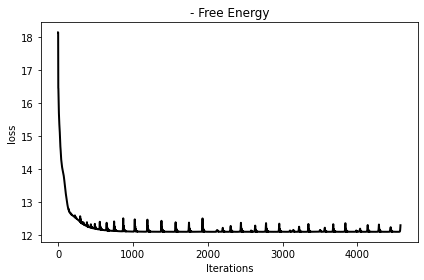

In [13]:
plot_loss(rpm, offset=0)

12.090625762939453


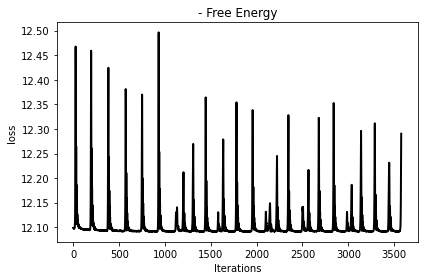

In [14]:
plot_loss(rpm, offset=1000)
print(np.min(rpm.loss_tot))

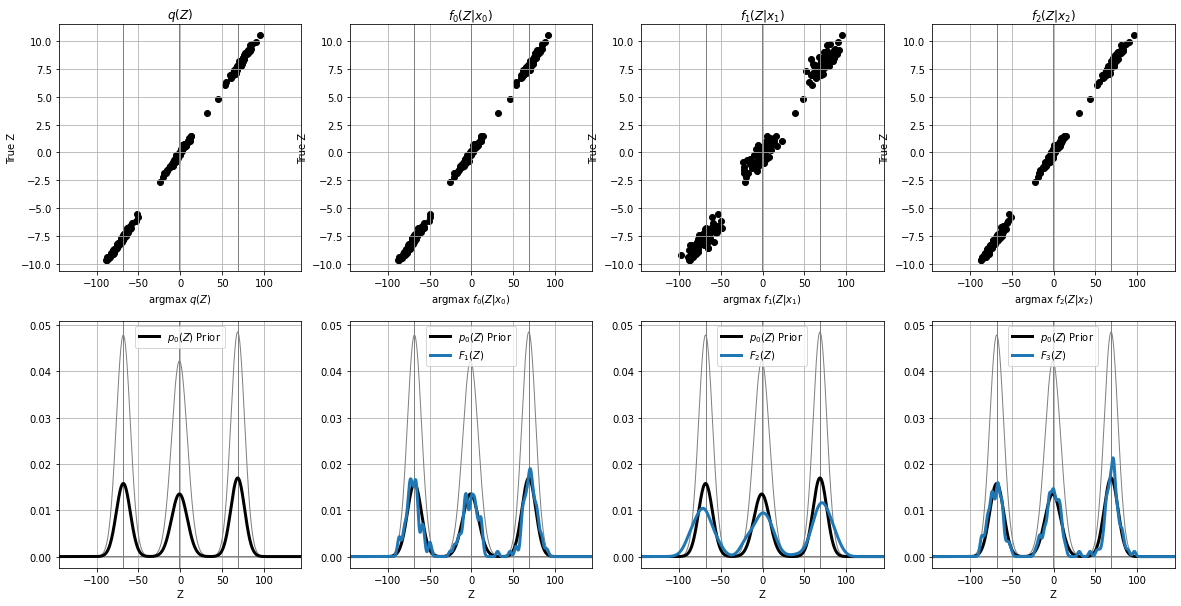

In [15]:
qdist, fdist = rpm.get_posteriors(observations)
qmean = qdist.mean_covariance()[0].to("cpu")
fmean = [fi.to("cpu") for fi in fdist.mean_covariance()[0]]

qvar = qdist.mean_covariance()[1][0].to("cpu")
fvar = [fi[0].to("cpu") for fi in fdist.mean_covariance()[1]]


plot_mean = [qmean, *fmean]
plot_var = [qvar, *fvar]
plot_title = [r'$q(Z)$', *[r'$f_ ' + str(ii) + '(Z | x_ ' + str(ii) + ')$' for ii,_ in enumerate(fmean) ]]

width = len(plot_mean)
heigh = 2
tru_posi = zlatent.to("cpu")

import flexible_multivariate_normal
with torch.no_grad():
    prior_dist = flexible_multivariate_normal.FlexibleMultivariateNormal(
        rpm.prior.natural1,
        rpm.prior.natural2(),
        init_cholesky=False,
        init_natural=True,
        store_suff_stat_mean=True,
    )
    
prior_mean, prior_covs = prior_dist.mean_covariance()
prior_mean = prior_mean.to("cpu")

with torch.no_grad():
    natural1_prior = rpm.prior.natural1.cpu()
    natural2_prior = rpm.prior.natural2().cpu()
    mixturew_prior = rpm.prior.responsabilities().cpu()
    
    natural1_factors, natural2_factors = [fi.cpu() for fi in rpm.forwarded_factors]
    
mixture_distributions = flexible_multivariate_normal.FlexibleMultivariateNormal(
    natural1_prior,
    natural2_prior,
    init_cholesky=False,
    init_natural=True,
    store_suff_stat_mean=True,
)

natural2_factors = natural2_factors.unsqueeze(1).repeat(1, natural1_factors.shape[1], 1, 1)

factors_distributions =flexible_multivariate_normal.FlexibleMultivariateNormal(
    natural1_factors,
    natural2_factors,
    init_cholesky=False,
    init_natural=True,
    store_suff_stat_mean=True,
)


zmin = 1.5 * np.min([ii.min() for ii in plot_mean])
zmax = 1.5 * np.max([ii.max() for ii in plot_mean])

zz = torch.linspace(zmin, zmax, 1000).unsqueeze(-1).unsqueeze(-1)
pdf_mixture_prior_all = torch.exp(mixture_distributions.log_prob(zz))
pdf_mixture_prior = (pdf_mixture_prior_all * mixturew_prior.unsqueeze(0)).sum(-1)
pdf_mixture_factors = torch.exp(factors_distributions.log_prob(zz.unsqueeze(1))).mean(-1)


pdf_mixture_prior = pdf_mixture_prior.numpy()
pdf_mixture_factors = pdf_mixture_factors.numpy()
pdf_mixture_prior_all = pdf_mixture_prior_all.numpy()


plt.figure(figsize=(width * 5, heigh * 5))
for ii, xmean in enumerate(plot_mean):
    plt.subplot(heigh, width, ii + 1)
    plt.scatter(xmean.numpy(), tru_posi.numpy(), c='k')
    for pp in range(prior_mean.shape[0]):
        plt.axvline(x = prior_mean[pp].numpy(), label='Prior Centroids', lw=1, c='gray')
    
    plt.ylabel('True Z')
    plt.xlabel('argmax ' + plot_title[ii])
    plt.xlim([zmin, zmax])
    
    plt.title(plot_title[ii])
    plt.grid()
    
    plt.subplot(heigh, width, ii + 1 + width)
    for jj in range(pdf_mixture_prior_all.shape[-1]):
        plt.plot(zz.squeeze(), pdf_mixture_prior_all[:, jj], lw =1, c='gray')
        plt.axvline(x = prior_mean[jj].numpy(), lw=1, c='gray')
        
    plt.plot(zz.squeeze(), pdf_mixture_prior, lw =3, c='k', label=r'$p_0(Z)$ Prior')
    plt.xlim([zmin, zmax])
    plt.xlabel('Z')
    if ii > 0:
        plt.plot(zz.squeeze(), pdf_mixture_factors[:, ii-1], label= r'$F_' + str(ii) + '(Z)$', lw=3)
    plt.grid()
    plt.legend()






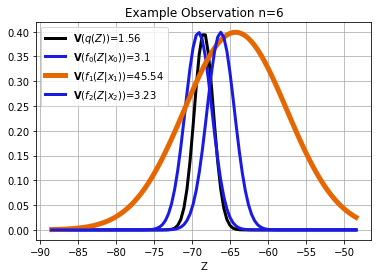

In [16]:
eg = 6
eg_mean = [mean[eg] for mean in plot_mean]
eg_vari = plot_var


tt_mean = tru_posi[eg].numpy()[0]
tt_mean = eg_mean[0].numpy()[0]

zmm = 20
zeval = torch.linspace(tt_mean-zmm, tt_mean + zmm, 100)

def gdensity1D(mean, sigma2):
    def func(z):
        return torch.exp( - 0.5 * (z- mean) ** 2 / sigma2) / torch.sqrt(2 * torch.tensor(np.pi))

    return func


colors = [
    [0.0, 0.0, 0.0],
    [0.1, 0.1, 0.9],
    [0.9, 0.4, 0.0],
    [0.1, 0.1, 0.9],
    [0.1, 0.1, 0.9],
]

linewidths = [
    3,
    3,
    5,
    3,
    3
]

plt.figure()
for ii, xmean in enumerate(eg_mean):
    xvari = eg_vari[ii] 
    dens = gdensity1D(xmean, xvari)(zeval).squeeze()
    plt.plot(zeval, dens, label= r'$\mathbf{V}$(' + plot_title[ii] + ')=' + str(np.round(eg_vari[ii], 2).numpy().squeeze()), c=colors[ii], lw = linewidths[ii])
    
plt.title('Example Observation n=' + str(eg))
plt.xlabel('Z')
plt.grid()
plt.legend()